In [36]:
"""
CryptoTrace Risk Engine - 1 Hour Snapshot Optimized
Context: Random 1-hour dataset (Real World Clean Data + Synthetic Injection)
"""

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

# =============================================================================
# 1. SETUP & LOAD DATA
# =============================================================================
print("[1] Loading Data...")

tx_path = '../data/raw/transaction.json'
wallet_path = '../data/raw/wallet.json'

try:
    with open(tx_path, 'r') as f:
        tx_data = json.load(f)
    df_tx = pd.DataFrame(tx_data)
    # Convert ke datetime di awal untuk ambil patokan waktu
    df_tx['BlockTime'] = pd.to_datetime(df_tx['BlockTime'], utc=True)
except Exception as e:
    print(f"Error: {e}")
    df_tx = pd.DataFrame()

with open(wallet_path, 'r') as f:
    wallet_data = json.load(f)
df_wallet = pd.DataFrame(wallet_data)
if 'address' in df_wallet.columns:
    df_wallet.set_index('address', inplace=True)

print(f"   - Original Transactions: {len(df_tx)}")

[1] Loading Data...
   - Original Transactions: 1000


In [37]:
# =============================================================================
# 2. SYNTHETIC INJECTION (DYNAMIC TIME ALIGNMENT)
# =============================================================================
print("\n[2] Injecting Bad Actors (Aligned with Real Data Time)...")

# Ambil waktu paling awal dari data asli sebagai patokan
# Agar si penjahat muncul di jam yang sama dengan data asli
if not df_tx.empty:
    start_time = df_tx['BlockTime'].min()
else:
    start_time = pd.Timestamp.now(tz='UTC')

print(f"   - Injection Base Time: {start_time}")

fake_txs = []

# Skenario 1: SMURFING (1 Sender -> 50 Receivers dalam 1 jam yang sama)
actor_smurf = "0xBAD_ACTOR_SMURFING"
for i in range(50):
    fake_txs.append({
        "PKID": 900000 + i,
        "BlockTime": start_time + pd.Timedelta(seconds=i*10), # Tiap 10 detik
        "FromAddress": actor_smurf,
        "ToAddress": f"0xRECEIVER_SMURF_{i}",
        "Amount": 2.0, 
        "Fee": 0.002, "RawData": {"input": "0x"}, "Network": "ethereum-mainnet"
    })

# Skenario 2: LAYERING (Masuk 500 -> Keluar 499 di menit yang sama)
actor_layer = "0xBAD_ACTOR_LAYERING"
fake_txs.append({
    "PKID": 910000,
    "BlockTime": start_time + pd.Timedelta(minutes=5),
    "FromAddress": "0xSOURCE_FUNDS",
    "ToAddress": actor_layer,
    "Amount": 500.0, 
    "Fee": 0.002, "RawData": {"input": "0x"}, "Network": "ethereum-mainnet"
})
fake_txs.append({
    "PKID": 910001,
    "BlockTime": start_time + pd.Timedelta(minutes=5, seconds=30), # Cuma beda 30 detik
    "FromAddress": actor_layer,
    "ToAddress": "0xFINAL_DEST",
    "Amount": 499.5,
    "Fee": 0.002, "RawData": {"input": "0x"}, "Network": "ethereum-mainnet"
})

# Skenario 3: SPAM BOT (100 txs dalam 1 jam)
actor_spam = "0xBAD_ACTOR_SPAMMER"
for i in range(100):
    fake_txs.append({
        "PKID": 920000 + i,
        "BlockTime": start_time + pd.Timedelta(seconds=i*5), # Sangat cepat
        "FromAddress": actor_spam,
        "ToAddress": "0xTARGET_CONTRACT",
        "Amount": 0.001,
        "Fee": 0.002, "RawData": {"input": "0x"}, "Network": "ethereum-mainnet"
    })

df_fake = pd.DataFrame(fake_txs)
df_tx = pd.concat([df_tx, df_fake], ignore_index=True)
# Pastikan tipe data datetime aman
df_tx['BlockTime'] = pd.to_datetime(df_tx['BlockTime'], utc=True)

print(f"   ✓ Injected 3 Scenarios")
print(f"   - Total Transactions: {len(df_tx)}")


[2] Injecting Bad Actors (Aligned with Real Data Time)...
   - Injection Base Time: 2025-11-20 15:38:47+00:00
   ✓ Injected 3 Scenarios
   - Total Transactions: 1152


In [38]:
# =============================================================================
# 3. FEATURE ENGINEERING (1-HOUR CONTEXT)
# =============================================================================
print("\n[3] Feature Engineering...")

df_tx['Amount'] = df_tx['Amount'].fillna(0)
df_tx['Fee'] = df_tx['Fee'].fillna(0)
df_tx['gas_fee_ratio'] = np.where(df_tx['Amount'] > 0, df_tx['Fee'] / df_tx['Amount'], 0)

# [REMOVED] is_night: Karena data cuma 1 jam, fitur ini tidak berguna (bias).

def is_round(amount):
    if amount > 0 and amount in [0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]:
        return 1
    return 0

df_tx['is_round'] = df_tx['Amount'].apply(is_round)



[3] Feature Engineering...


In [39]:
# =============================================================================
# 4. AGGREGATION
# =============================================================================
print("\n[4] Aggregating Profiles...")

def get_wallet_features(df_tx, address_col):
    grp = df_tx.groupby(address_col)
    
    features = grp.agg({
        'PKID': 'count',
        'Amount': ['sum', 'mean', 'max'],
        'gas_fee_ratio': 'mean',
        'is_round': 'mean'
    })
    
    features.columns = ['_'.join(col).strip() for col in features.columns.values]
    features.rename(columns={'PKID_count': 'tx_count'}, inplace=True)
    
    # Time diffs (Velocity)
    def avg_time_diff(x):
        if len(x) < 2: return 0
        return x.sort_values().diff().dt.total_seconds().mean()
    
    features['avg_seconds_between_tx'] = grp['BlockTime'].apply(avg_time_diff)
    
    # Counterparties
    c_col = 'ToAddress' if address_col == 'FromAddress' else 'FromAddress'
    features['unique_counterparties'] = grp[c_col].nunique()
    
    # [NEW] Transactions Per Minute (Velocity)
    # Asumsi window data adalah max(time) - min(time) dari transaksi wallet tsb
    def tx_velocity(x):
        if len(x) < 2: return 0
        duration_min = (x.max() - x.min()).total_seconds() / 60
        return len(x) / (duration_min + 1) # +1 prevent div by zero
        
    features['tx_per_minute'] = grp['BlockTime'].apply(tx_velocity)

    return features

df_from = get_wallet_features(df_tx, 'FromAddress')
df_to = get_wallet_features(df_tx, 'ToAddress')

df_from.columns = ['snd_' + c for c in df_from.columns]
df_to.columns = ['rcv_' + c for c in df_to.columns]

final_df = df_wallet.join(df_from, how='outer').join(df_to, how='outer').fillna(0)
active_wallets = final_df[(final_df['snd_tx_count'] > 0) | (final_df['rcv_tx_count'] > 0)].copy()



[4] Aggregating Profiles...


C:\Users\acer\AppData\Local\Temp\ipykernel_26964\1074994716.py:47: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_df = df_wallet.join(df_from, how='outer').join(df_to, how='outer').fillna(0)


In [40]:
# =============================================================================
# 5. RISK INDICATORS (REALISTIC FOR 1-HOUR DATA)
# =============================================================================
print("\n[5] Calculating Risk Indicators...")

# 1. Structuring (Smurfing)
# Rumus: Unique Receivers yang banyak + Volume
active_wallets['structuring_score'] = 0.0
mask_struct = active_wallets['snd_tx_count'] >= 5 # Lower threshold for 1-hour
active_wallets.loc[mask_struct, 'structuring_score'] = (
    active_wallets.loc[mask_struct, 'snd_unique_counterparties'] / 
    (active_wallets.loc[mask_struct, 'snd_tx_count'] + 1)
) * np.log1p(active_wallets.loc[mask_struct, 'snd_tx_count'])

# 2. Pass-through (Money Mule / Layering)
# Masuk -> Keluar dalam waktu singkat
active_wallets['passthrough_score'] = 0.0
# Cek flow ratio: Out / In mendekati 1
active_wallets['flow_ratio'] = np.where(active_wallets['rcv_Amount_sum'] > 0,
                                        active_wallets['snd_Amount_sum'] / active_wallets['rcv_Amount_sum'],
                                        0)
mask_pass = (
    (active_wallets['flow_ratio'] >= 0.9) & 
    (active_wallets['flow_ratio'] <= 1.1) &
    (active_wallets['snd_Amount_sum'] > 10) # Minimal 10 ETH agar tidak kena recehan
)
active_wallets.loc[mask_pass, 'passthrough_score'] = 100.0 # Langsung flag tinggi

# 3. Spam/Bot Behavior (High velocity)
active_wallets['bot_score'] = active_wallets['snd_tx_per_minute']



[5] Calculating Risk Indicators...


In [41]:
# =============================================================================
# 6. ML (STRICTER FILTER)
# =============================================================================
print("\n[6] Running ML Models...")

ml_features = [
    'snd_tx_count', 'snd_Amount_sum', 'snd_unique_counterparties', 
    'structuring_score', 'passthrough_score', 'bot_score'
]

# Strict Filter: Hanya ML pada wallet yang "Sibuk" (>2 tx)
# Wallet yang cuma 1 tx (sebagian besar user) diabaikan ML-nya agar tidak bias
ml_subset = active_wallets[active_wallets['snd_tx_count'] >= 2].copy()

if len(ml_subset) > 5: # Butuh minimal data points
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(ml_subset[ml_features])
    
    # 5% Contamination
    iso = IsolationForest(contamination=0.05, random_state=42)
    iso_scores = iso.fit_predict(X_scaled)
    raw_iso = iso.score_samples(X_scaled)
    
    lof = LocalOutlierFactor(n_neighbors=min(20, len(ml_subset)-1), contamination=0.05)
    lof_scores = lof.fit_predict(X_scaled)
    raw_lof = lof.negative_outlier_factor_
    
    def norm(s): return ((s.max() - s) / (s.max() - s.min() + 1e-10)) * 100
    
    ml_subset['risk_score_ml'] = (norm(raw_iso) + norm(raw_lof)) / 2
    active_wallets = active_wallets.join(ml_subset[['risk_score_ml']], how='left')
    active_wallets['risk_score_ml'] = active_wallets['risk_score_ml'].fillna(0)
else:
    active_wallets['risk_score_ml'] = 0



[6] Running ML Models...


In [42]:
# =============================================================================
# 7. RULE-BASED SCORING (LOGIKA 1-JAM)
# =============================================================================
print("\n[7] Calculating Rules...")

def calculate_rules(row):
    score = 0
    
    # Rule 1: Layering (Critical)
    # Jika passthrough score aktif (rasio 1:1), itu tanda bahaya besar
    if row['passthrough_score'] > 0:
        score += 80
        
    # Rule 2: Smurfing / Structuring
    # Kirim ke > 20 orang dalam 1 jam? Aneh.
    if row['structuring_score'] > 2.0: score += 60
    elif row['structuring_score'] > 1.0: score += 30
    
    # Rule 3: Spamming
    # > 20 tx per menit? Pasti bot.
    if row['bot_score'] > 20: score += 50
    elif row['bot_score'] > 5: score += 20
    
    # Rule 4: Volume Anomaly (Dalam 1 Jam)
    # Jika volume > 100 ETH dalam 1 jam, itu Whale/Exchange/Hacker
    if row['snd_Amount_sum'] > 100: score += 20
    
    return min(score, 100)

active_wallets['risk_score_rule'] = active_wallets.apply(calculate_rules, axis=1)



[7] Calculating Rules...


In [43]:
# =============================================================================
# 8. FINAL SCORE
# =============================================================================
print("\n[8] Computing Final Scores...")

# 30% ML, 70% Rules (Karena data real sangat sedikit, ML kurang reliable)
active_wallets['FINAL_RISK_SCORE'] = (
    0.3 * active_wallets['risk_score_ml'] + 
    0.7 * active_wallets['risk_score_rule']
)
active_wallets['FINAL_RISK_SCORE'] = active_wallets['FINAL_RISK_SCORE'].clip(upper=100)

def get_label(s):
    if s >= 75: return 'CRITICAL'
    if s >= 50: return 'HIGH'
    if s >= 25: return 'MEDIUM'
    return 'LOW'

active_wallets['Risk_Level'] = active_wallets['FINAL_RISK_SCORE'].apply(get_label)



[8] Computing Final Scores...


In [44]:
# =============================================================================
# 9. VALIDATION REPORT
# =============================================================================
print("\n" + "="*70)
print("VALIDATION: TARGET DETECTION CHECK")
print("="*70)

targets = [actor_smurf, actor_layer, actor_spam]

for target in targets:
    if target in active_wallets.index:
        row = active_wallets.loc[target]
        print(f"Address: {target}")
        print(f"Score  : {row['FINAL_RISK_SCORE']:.1f} ({row['Risk_Level']})")
        print(f"Status : {'✅ DETECTED' if row['FINAL_RISK_SCORE'] > 60 else '❌ MISSED'}")
        print(f"Details: PassThrough={row['passthrough_score']}, Struct={row['structuring_score']:.2f}, Bot={row['bot_score']:.2f}")
        print("-" * 50)

# Cek False Positive
print("\n[False Positive Check on Real Data]")
# Ambil data asli (yang bukan bad actor)
real_wallets = active_wallets[~active_wallets.index.isin(targets)]
high_risk_real = real_wallets[real_wallets['FINAL_RISK_SCORE'] > 50]

if len(high_risk_real) == 0:
    print("✅ PERFECT! No real wallets flagged as HIGH risk (Clean Dataset confirmed).")
else:
    print(f"⚠️ WARNING: {len(high_risk_real)} real wallets flagged as HIGH/CRITICAL.")
    print(high_risk_real[['FINAL_RISK_SCORE', 'snd_tx_count', 'snd_Amount_sum']].head())

# =============================================================================
# 10. EXPORT
# =============================================================================
output_dir = '../data/processed'
if not os.path.exists(output_dir): os.makedirs(output_dir)
active_wallets.to_csv(os.path.join(output_dir, 'wallet_risk_scored_final.csv'))
print(f"\nSaved results to {output_dir}")


VALIDATION: TARGET DETECTION CHECK
Address: 0xBAD_ACTOR_SMURFING
Score  : 86.0 (CRITICAL)
Status : ✅ DETECTED
Details: PassThrough=0.0, Struct=3.85, Bot=5.45
--------------------------------------------------
Address: 0xBAD_ACTOR_LAYERING
Score  : 70.0 (HIGH)
Status : ✅ DETECTED
Details: PassThrough=100.0, Struct=0.00, Bot=0.00
--------------------------------------------------
Address: 0xBAD_ACTOR_SPAMMER
Score  : 27.2 (MEDIUM)
Status : ❌ MISSED
Details: PassThrough=0.0, Struct=0.05, Bot=10.81
--------------------------------------------------

[False Positive Check on Real Data]
⚠️ WARNING: 1 real wallets flagged as HIGH/CRITICAL.
                                            FINAL_RISK_SCORE  snd_tx_count  \
0x974caa59e49682cda0ad2bbe82983419a2ecc400          52.04271          13.0   

                                            snd_Amount_sum  
0x974caa59e49682cda0ad2bbe82983419a2ecc400        0.305142  

Saved results to ../data/processed


In [45]:
print("\nTop 30 Highest Risk Wallets")
top30 = active_wallets.sort_values(by="FINAL_RISK_SCORE", ascending=False).head(30)
display(top30[['FINAL_RISK_SCORE', 'Risk_Level', 'snd_tx_count', 
               'snd_Amount_sum', 'structuring_score', 
               'passthrough_score', 'bot_score']])



Top 30 Highest Risk Wallets


,FINAL_RISK_SCORE,Risk_Level,snd_tx_count,snd_Amount_sum,structuring_score,passthrough_score,bot_score
0xBAD_ACTOR_SMURFING,86.000000,CRITICAL,50.0,100.000000,3.854731,0.0,5.454545
0xBAD_ACTOR_LAYERING,70.000000,HIGH,1.0,499.500000,0.000000,100.0,0.000000
0x974caa59e49682cda0ad2bbe82983419a2ecc400,52.042710,HIGH,13.0,0.305142,2.262049,0.0,0.264228
0x46340b20830761efd32832a74d7169b29feb9758,32.418957,MEDIUM,9.0,6.943436,1.842068,0.0,0.201794
0x21a31ee1afc51d94c2efccaa2092ad1028285549,27.837725,MEDIUM,9.0,0.000000,1.611810,0.0,0.158451
0xBAD_ACTOR_SPAMMER,27.181931,MEDIUM,100.0,0.100000,0.045694,0.0,10.810811
0x0d0707963952f2fba59dd06f2b425ace40b492fe,27.033284,MEDIUM,5.0,0.519704,1.493133,0.0,0.106838
0xdfd5293d8e347dfe59e90efd55b2956a1343963d,26.255372,MEDIUM,7.0,0.410584,1.039721,0.0,0.180412
0xf70da97812cb96acdf810712aa562db8dfa3dbef,26.001962,MEDIUM,5.0,0.020017,1.493133,0.0,0.373134
0x264bd8291fae1d75db2c5f573b07faa6715997b5,25.658230,MEDIUM,7.0,0.159334,1.299651,0.0,0.177665


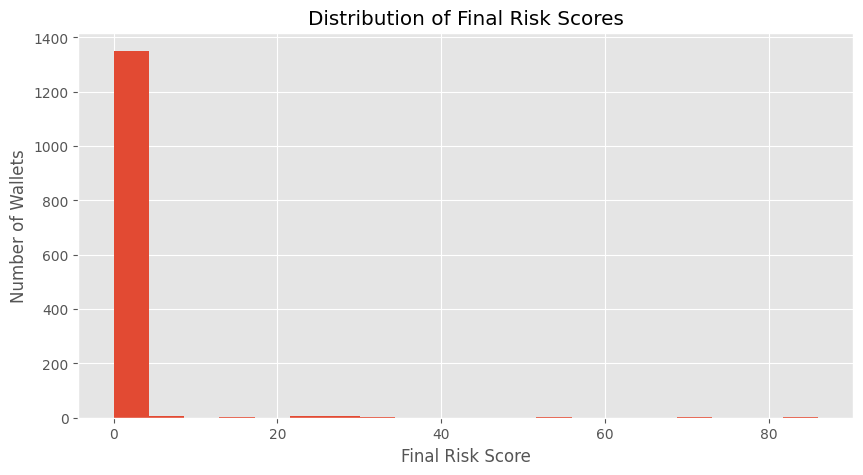

In [46]:
plt.figure(figsize=(10,5))
plt.hist(active_wallets['FINAL_RISK_SCORE'], bins=20)
plt.title("Distribution of Final Risk Scores")
plt.xlabel("Final Risk Score")
plt.ylabel("Number of Wallets")
plt.show()


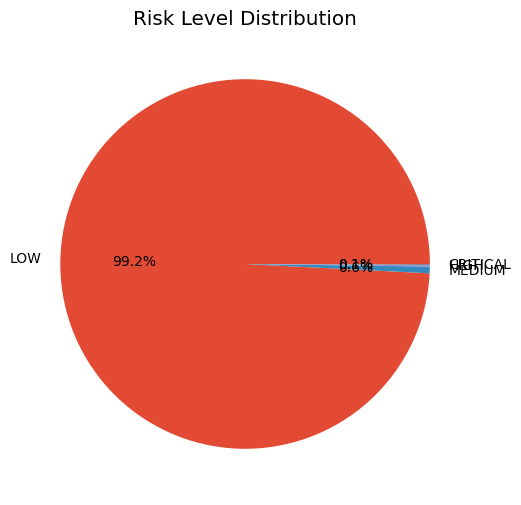

In [47]:
plt.figure(figsize=(6,6))
active_wallets['Risk_Level'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Risk Level Distribution")
plt.ylabel("")
plt.show()


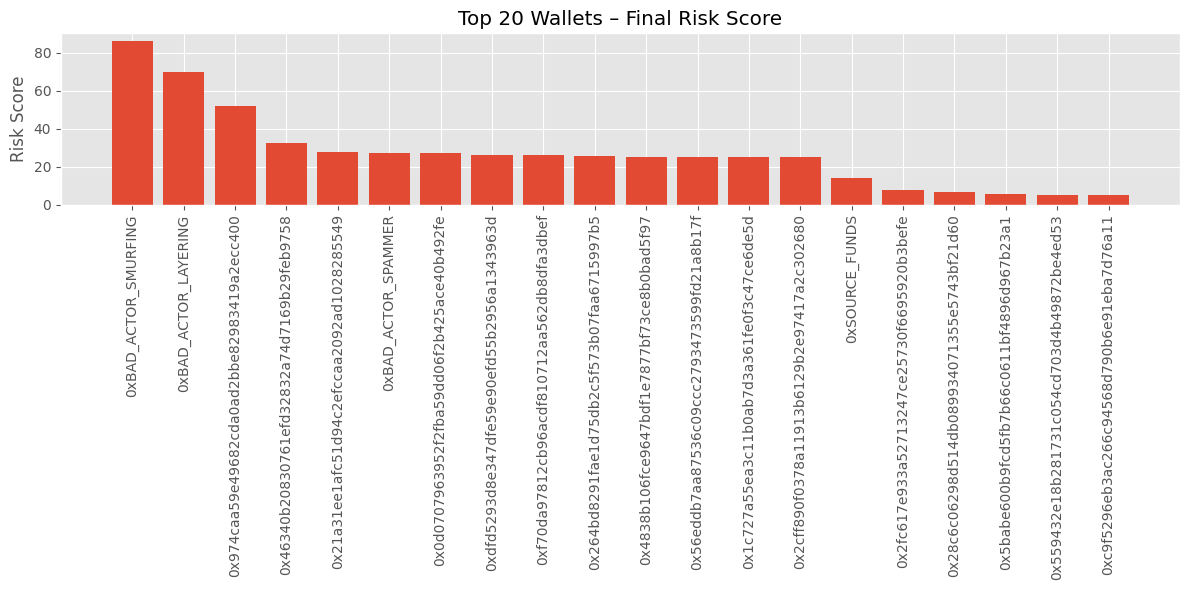

In [48]:
top20 = active_wallets.sort_values(by="FINAL_RISK_SCORE", ascending=False).head(20)

plt.figure(figsize=(12,6))
plt.bar(top20.index.astype(str), top20['FINAL_RISK_SCORE'])
plt.xticks(rotation=90)
plt.title("Top 20 Wallets – Final Risk Score")
plt.ylabel("Risk Score")
plt.tight_layout()
plt.show()


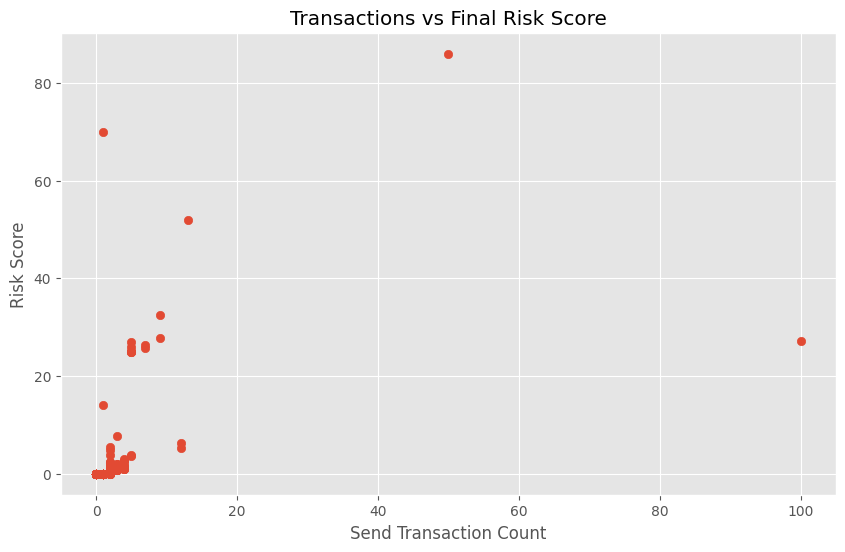

In [49]:
plt.figure(figsize=(10,6))
plt.scatter(active_wallets['snd_tx_count'], active_wallets['FINAL_RISK_SCORE'])
plt.title("Transactions vs Final Risk Score")
plt.xlabel("Send Transaction Count")
plt.ylabel("Risk Score")
plt.grid(True)
plt.show()


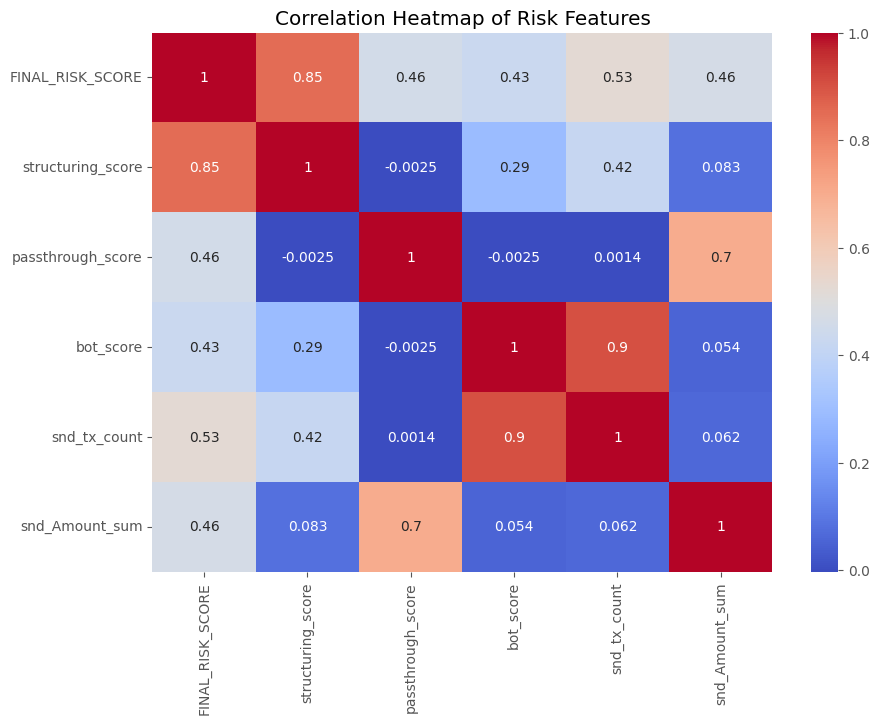

In [50]:
plt.figure(figsize=(10,7))
sns.heatmap(active_wallets[['FINAL_RISK_SCORE','structuring_score',
                            'passthrough_score','bot_score',
                            'snd_tx_count','snd_Amount_sum']].corr(),
            annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Risk Features")
plt.show()
